# Imports

In [39]:
import datetime
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply

# Load & Process data

In [5]:
data = pd.read_csv("data\BTCUSDT-1m-2023-01.csv",
                   usecols = [0,1,2,3,4],
                   names = ["Date","Open","High","Low","Close"])
data["Date"] = pd.to_datetime(data["Date"], unit = "ms")
data.set_index("Date", inplace=True)
#data = data.iloc[0:20000]

factor = 1_000_000
data['Open'] /= factor
data['High'] /= factor
data['Low'] /= factor
data['Close'] /= factor

# Strategy Class

In [68]:
def indicator(data):
    # % increase in stock over 7 periods
    return data.pct_change(periods = 7) * 100

class MomentumStrategy(Strategy):

    small_threshold = 0
    large_threshold = 3

    # Do as much initial computation as possible
    def init(self):
        
        self.short_pct_change = resample_apply(
            '15min', indicator, self.data.Close.s)
        self.long_pct_change = resample_apply(
            '1h', indicator, self.data.Close.s)

    # MB - Any dollar amounts must be divided by factor
    def next(self):
        change_short = self.short_pct_change[-1]
        change_long = self.long_pct_change[-1]
        price = self.data.Close[-1]

        if self.position:
            if self.position.is_long and change_short < self.small_threshold:
                self.position.close()
            elif self.position.is_short and change_short > -self.small_threshold:
                self.position.close()

        else:
            if change_short > self.small_threshold and change_long > self.large_threshold:
                stop = price - (change_short / 100) * price
                oneR = abs(price - stop)
                self.buy(size=1, sl=stop, tag=oneR)

            elif change_short < -self.small_threshold and change_long < -self.large_threshold:
                stop = price - (change_long / 100) * price
                oneR = abs(price - stop)
                self.sell(size=1, sl=stop, tag=oneR)

# Test Run

In [8]:
bt = Backtest(data, MomentumStrategy, cash=100, commission=0.002/factor)

stats = bt.optimize(
    small_threshold = list(np.arange(0,1,0.1)),
    large_threshold = list(np.arange(1,3,0.2)),
    maximize = "Equity Final [$]"
    )
bt.plot(resample=False)

trades = stats['_trades'].drop('ReturnPct', axis=1)
trades.EntryPrice = round(trades.EntryPrice * factor,2)
trades.ExitPrice = round(trades.ExitPrice * factor,2)
trades.PnL = round(trades.PnL,2)
trades.StopLoss = round(trades.StopLoss * factor,2)
trades.oneR = round(trades.oneR * factor,2)

print(stats)
print(trades.to_string())

Start                     2023-01-01 00:00:00
End                       2023-01-31 23:59:00
Duration                     30 days 23:59:00
Exposure Time [%]                    7.058692
Equity Final [$]                   103.697936
Equity Peak [$]                    109.234604
Return [R]                           3.697936
Buy & Hold Return [%]               39.782346
Return (Ann.) [%]                   53.348796
Volatility (Ann.) [%]               30.124129
Max. Drawdown [%]                    -5.24705
Avg. Drawdown [%]                   -0.535336
Max. Drawdown Duration       11 days 21:24:00
Avg. Drawdown Duration        0 days 17:48:00
# Trades                                   33
Win Rate [%]                        39.393939
Best Trade [R]                        7.41301
Worst Trade [R]                      -1.00487
Expectancy (mean R)                  0.112059
Max. Trade Duration           0 days 05:30:00
Avg. Trade Duration           0 days 01:35:00
Profit Factor                     

# Walk forward

In [10]:
def walk_forward(
    strategy,
    data_full,
    warmup_bars,
    lookback_bars,
    validation_bars,
    cash = 100,
    commission = 0.002/factor
    ):

    stats_master = []

    for i in range(lookback_bars + warmup_bars, len(data_full) - validation_bars, validation_bars):
        
        training_data = data_full.iloc[i-lookback_bars-warmup_bars:i]
        validation_data = data_full.iloc[i-warmup_bars:i+validation_bars]

        bt_training = Backtest(training_data, strategy, cash=cash, commission=commission)
        stats_training = bt_training.optimize(
            small_threshold = list(np.arange(0,1,0.1)),
            large_threshold = list(np.arange(1,3,0.2)),
            maximize = "Equity Final [$]"
            )
        
        small_threshold = stats_training._strategy.small_threshold
        large_threshold = stats_training._strategy.large_threshold

        bt_validation = Backtest(validation_data, strategy, cash=cash, commission=commission)
        stats_validation = bt_validation.run(
                                small_threshold = small_threshold,
                                large_threshold = large_threshold,
                                )
        stats_master.append(stats_validation)

    return stats_master

# Run Walk-Forward

In [69]:
lookback_bars = 14*1440
validation_bars = 2*1440
warmup_bars = 8*60

stats = walk_forward(
    MomentumStrategy,
    data,
    lookback_bars=lookback_bars,
    validation_bars=validation_bars,
    warmup_bars=warmup_bars)

# Plots

# Plot stats of a particular result

In [61]:
def plot_stats(data_full, stats):
    equity_curve = stats._equity_curve
    aligned_data = data_full.reindex(equity_curve.index)
    
    bt = Backtest(aligned_data, MomentumStrategy, cash=100, commission=0.002)
    bt.plot(results = stats)

In [70]:
plot_stats(data, stats[5])

# Plot full equity curve of all validation tests

In [73]:
def plot_full_equity_curve(
    data,
    stats_list,
    warmup_bars,
    lookback_bars):
    
    equity_curves = [x["_equity_curve"].iloc[warmup_bars:] for x in stats_list]
    
    combined = pd.Series(dtype="float64")
    for curve in equity_curves:
        if len(combined) == 0:
            combined = curve["Equity"]/100
        else:
            combined = pd.concat([combined, (curve["Equity"]/100)*combined.iloc[-1]]) 
                                             
    aligned_price_data = data[data.index <= combined.index[-1]].iloc[lookback_bars + warmup_bars:]
    
    fig, ax1 = plt.subplots()
    ax1.plot(combined.index, combined, color="orange")
    ax2 = ax1.twinx()
    ax2.plot(aligned_price_data.index, aligned_price_data.Close*factor)
    
    plt.show()

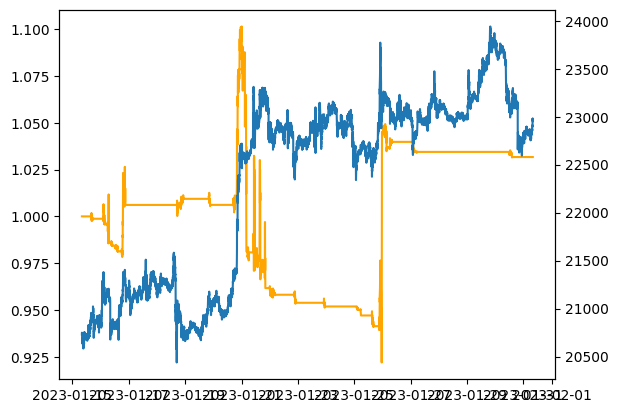

In [74]:
plot_full_equity_curve(data, stats, warmup_bars, lookback_bars)

# Plot walkforward periods

In [58]:
def plot_period_graph(
    data,
    lookback_bars,
    validation_bars):
    
    ranges = list(range(lookback_bars + warmup_bars, len(data) - validation_bars, validation_bars))
    
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    
    for i in range(len(ranges)):
        
        training_data = data.iloc[ranges[i]-lookback_bars:ranges[i]]
        validation_data = data.iloc[ranges[i]:ranges[i]+validation_bars]
        
        plt.fill_between(training_data.index,
                        [len(ranges) - i - 0.5]*len(training_data.index),
                        [len(ranges) - i + 0.5]*len(training_data.index),
                         color = "blue"
                        )
        
        plt.fill_between(validation_data.index,
                        [len(ranges) - i - 0.5]*len(validation_data.index),
                        [len(ranges) - i + 0.5]*len(validation_data.index),
                         color = "orange"
                        )
    
    plt.show()

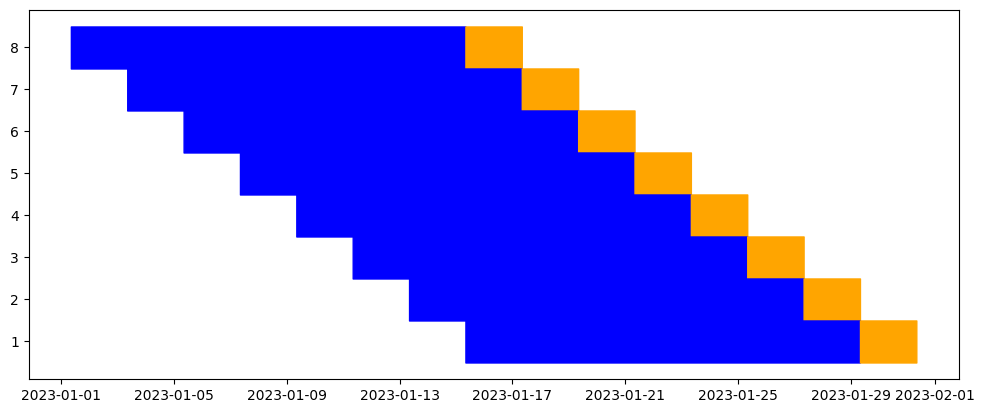

In [72]:
plot_period_graph(data,lookback_bars,validation_bars)